In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import os

In [2]:
import torchvision.models as models
net = models.resnet18()

In [3]:
net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [4]:
net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
net.fc = nn.Linear(in_features=512, out_features=3, bias=True)

In [5]:
net

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
if torch.cuda.is_available():
    net = net.cuda()

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [9]:
def UploadData(path, train):
    #set up transforms for train and test datasets
    train_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.Resize(512), transforms.CenterCrop(511), transforms.RandomRotation(30),transforms.RandomHorizontalFlip(), transforms.transforms.ToTensor()]) 
    valid_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.Resize(512), transforms.CenterCrop(511), transforms.transforms.ToTensor()]) 
    #test_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.Resize(512), transforms.CenterCrop(511), transforms.ToTensor()])
    
    #set up datasets from Image Folders
    train_dataset = datasets.ImageFolder(path + '/train', transform=train_transforms)
    valid_dataset = datasets.ImageFolder(path + '/validation', transform=valid_transforms)
    #test_dataset = datasets.ImageFolder(path + '/test', transform=test_transforms)

    #set up dataloaders with batch size of 32
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=12, shuffle=True)
    #testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
  
    return trainloader, validloader #, testloader

In [10]:
trainloader, validloader = UploadData("/home/user/research/CXR_Covid-19_Challenge", True) #, testloader

In [11]:
trainloader.dataset.class_to_idx

{'covid': 0, 'normal': 1, 'pneumonia': 2}

In [12]:
import time
from tqdm import tqdm
from playsound import playsound
def convert(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [13]:
min_valid_loss = np.inf

In [14]:
loss_train_list = []
loss_valid_list = []
acc_train_list = []
acc_valid_list = []
epochs = 100
total_time = time.time()
for e in range(epochs):
    start_time=time.time()
    train_loss = 0.0
    right_train = 0
    total_train = 0
    for data, labels in tqdm(trainloader):
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
         
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        target = net(data)
        _, predicted = torch.max(target, 1)
        # Find the Loss
        loss = criterion(target,labels)
        # Calculate gradients
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item()
        correct = (predicted == labels).float().sum()
        right_train+=correct.float()
        total_train+=len(predicted)
     
    valid_loss = 0.0
    right_valid = 0
    total_valid = 0
    net.eval()     # Optional when not using Model Specific layer
    for data, labels in tqdm(validloader):
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
         
        # Forward Pass
        target = net(data)
        _, predicted = torch.max(target, 1)
        # Find the Loss
        loss = criterion(target,labels)
        # Calculate Loss
        valid_loss += loss.item()
        correct = (predicted == labels).float().sum()
        right_valid+=correct.float()
        total_valid+=len(predicted)
    ftloss = train_loss / len(trainloader)
    fvloss = valid_loss / len(validloader)
    ftacc = float(right_train*100/total_train)
    fvacc = float(right_valid*100/total_valid)
    loss_train_list.append(ftloss)
    loss_valid_list.append(fvloss)
    acc_train_list.append(ftacc)
    acc_valid_list.append(fvacc)
    print('Epoch',e+1, '\tTraining Loss:',ftloss,'\tValidation Loss:',fvloss,"\t time:",convert(time.time()-start_time))
    print("Train Accuracy :",ftacc,"\tValidation Accuracy :",fvacc)
    if min_valid_loss > valid_loss:
        print("Validation Loss Decreased(",min_valid_loss,"--->",valid_loss,") \t Saving The Model")
        min_valid_loss = valid_loss
         
        # Saving State Dict
        torch.save(net.state_dict(), '/home/user/research/resnet18/resent_model.pth')
print("total time : ",convert(time.time()-total_time))
playsound('/home/user/research/audio')

  0%|          | 0/1497 [00:00<?, ?it/s]/home/user/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 286/286 [01:23<00:00,  3.42it/s]


Epoch 1 	Training Loss: 0.914432241905508 	Validation Loss: 5.409840382896103 	 time: 00:15:15
Train Accuracy : 58.35839080810547 	Validation Accuracy : 41.695804595947266
Validation Loss Decreased( inf ---> 1547.2143495082855 ) 	 Saving The Model


100%|██████████| 286/286 [00:56<00:00,  5.05it/s]


Epoch 2 	Training Loss: 1.0890498682110008 	Validation Loss: 1.095459109836525 	 time: 00:09:29
Train Accuracy : 38.974273681640625 	Validation Accuracy : 42.07459259033203
Validation Loss Decreased( 1547.2143495082855 ---> 313.30130541324615 ) 	 Saving The Model


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 3 	Training Loss: 1.0662257934540371 	Validation Loss: 1.0233849641326425 	 time: 00:09:55
Train Accuracy : 41.86991882324219 	Validation Accuracy : 50.786712646484375
Validation Loss Decreased( 313.30130541324615 ---> 292.68809974193573 ) 	 Saving The Model


100%|██████████| 286/286 [01:06<00:00,  4.33it/s]


Epoch 4 	Training Loss: 0.9452635404780139 	Validation Loss: 0.9735279810595345 	 time: 00:10:57
Train Accuracy : 53.82002258300781 	Validation Accuracy : 53.93356704711914
Validation Loss Decreased( 292.68809974193573 ---> 278.4290025830269 ) 	 Saving The Model


100%|██████████| 286/286 [01:02<00:00,  4.58it/s]


Epoch 5 	Training Loss: 0.8404942769644336 	Validation Loss: 0.7909036162016275 	 time: 00:10:54
Train Accuracy : 62.150569915771484 	Validation Accuracy : 67.04545593261719
Validation Loss Decreased( 278.4290025830269 ---> 226.19843423366547 ) 	 Saving The Model


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 6 	Training Loss: 0.7515576027219265 	Validation Loss: 0.6617921316227713 	 time: 00:10:57
Train Accuracy : 67.65229797363281 	Validation Accuracy : 72.29021453857422
Validation Loss Decreased( 226.19843423366547 ---> 189.2725496441126 ) 	 Saving The Model


100%|██████████| 286/286 [01:03<00:00,  4.53it/s]


Epoch 7 	Training Loss: 0.6553787542587929 	Validation Loss: 0.600804440729268 	 time: 00:11:07
Train Accuracy : 72.93128204345703 	Validation Accuracy : 75.96154022216797
Validation Loss Decreased( 189.2725496441126 ---> 171.83007004857063 ) 	 Saving The Model


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 8 	Training Loss: 0.5984709460211143 	Validation Loss: 0.6025271806996185 	 time: 00:11:12
Train Accuracy : 75.7545394897461 	Validation Accuracy : 76.34032440185547


100%|██████████| 286/286 [01:04<00:00,  4.46it/s]


Epoch 9 	Training Loss: 0.5494870943830422 	Validation Loss: 0.5079557338169405 	 time: 00:11:09
Train Accuracy : 78.23253631591797 	Validation Accuracy : 80.97319793701172
Validation Loss Decreased( 171.83007004857063 ---> 145.27533987164497 ) 	 Saving The Model


100%|██████████| 286/286 [01:06<00:00,  4.33it/s]


Epoch 10 	Training Loss: 0.507801607659282 	Validation Loss: 0.470249051397497 	 time: 00:11:11
Train Accuracy : 79.93094635009766 	Validation Accuracy : 82.54662322998047
Validation Loss Decreased( 145.27533987164497 ---> 134.49122869968414 ) 	 Saving The Model


100%|██████████| 286/286 [01:05<00:00,  4.34it/s]


Epoch 11 	Training Loss: 0.475695323052212 	Validation Loss: 0.4123567695618718 	 time: 00:11:21
Train Accuracy : 81.49014282226562 	Validation Accuracy : 84.76107788085938
Validation Loss Decreased( 134.49122869968414 ---> 117.93403609469533 ) 	 Saving The Model


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 12 	Training Loss: 0.4427371546775401 	Validation Loss: 0.4919014720676037 	 time: 00:11:23
Train Accuracy : 83.03820037841797 	Validation Accuracy : 82.28438568115234


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 13 	Training Loss: 0.4208838353275695 	Validation Loss: 0.4265763459245225 	 time: 00:11:19
Train Accuracy : 84.1463394165039 	Validation Accuracy : 84.00350189208984


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 14 	Training Loss: 0.4047454656782991 	Validation Loss: 0.4179441516215985 	 time: 00:09:54
Train Accuracy : 84.70319366455078 	Validation Accuracy : 84.09091186523438


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 15 	Training Loss: 0.3814310352134462 	Validation Loss: 0.5162362984896123 	 time: 00:09:29
Train Accuracy : 85.55518341064453 	Validation Accuracy : 80.50699615478516


100%|██████████| 286/286 [00:55<00:00,  5.14it/s]


Epoch 16 	Training Loss: 0.36165558965099043 	Validation Loss: 0.40533430202883647 	 time: 00:09:37
Train Accuracy : 86.44615173339844 	Validation Accuracy : 85.05245208740234
Validation Loss Decreased( 117.93403609469533 ---> 115.92561038024724 ) 	 Saving The Model


100%|██████████| 286/286 [00:57<00:00,  5.00it/s]


Epoch 17 	Training Loss: 0.3499462316397505 	Validation Loss: 0.39853324747230806 	 time: 00:09:37
Train Accuracy : 86.72457885742188 	Validation Accuracy : 85.81002807617188
Validation Loss Decreased( 115.92561038024724 ---> 113.9805087770801 ) 	 Saving The Model


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 18 	Training Loss: 0.3417469370132219 	Validation Loss: 0.35603674894550463 	 time: 00:10:13
Train Accuracy : 87.13665008544922 	Validation Accuracy : 86.74242401123047
Validation Loss Decreased( 113.9805087770801 ---> 101.82651019841433 ) 	 Saving The Model


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 19 	Training Loss: 0.32446076793741724 	Validation Loss: 0.3297091824608249 	 time: 00:11:22
Train Accuracy : 87.7658920288086 	Validation Accuracy : 87.6748275756836
Validation Loss Decreased( 101.82651019841433 ---> 94.29682618379593 ) 	 Saving The Model


100%|██████████| 286/286 [01:10<00:00,  4.05it/s]


Epoch 20 	Training Loss: 0.3128658552220466 	Validation Loss: 0.3081557689677481 	 time: 00:11:55
Train Accuracy : 88.30047607421875 	Validation Accuracy : 88.37413024902344
Validation Loss Decreased( 94.29682618379593 ---> 88.13254992477596 ) 	 Saving The Model


100%|██████████| 286/286 [01:11<00:00,  3.99it/s]


Epoch 21 	Training Loss: 0.30718623231860026 	Validation Loss: 0.2822078019266596 	 time: 00:12:16
Train Accuracy : 88.75152587890625 	Validation Accuracy : 89.53962707519531
Validation Loss Decreased( 88.13254992477596 ---> 80.71143135102466 ) 	 Saving The Model


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 22 	Training Loss: 0.29598417520863995 	Validation Loss: 0.3331428560529269 	 time: 00:12:26
Train Accuracy : 89.07450103759766 	Validation Accuracy : 87.47086334228516


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 23 	Training Loss: 0.29296387868150126 	Validation Loss: 0.42421120914493826 	 time: 00:12:52
Train Accuracy : 89.0967788696289 	Validation Accuracy : 85.13986206054688


100%|██████████| 286/286 [01:11<00:00,  4.01it/s]


Epoch 24 	Training Loss: 0.28096779631407226 	Validation Loss: 0.27224766077486784 	 time: 00:12:56
Train Accuracy : 89.78170776367188 	Validation Accuracy : 89.7144546508789
Validation Loss Decreased( 80.71143135102466 ---> 77.8628309816122 ) 	 Saving The Model


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 25 	Training Loss: 0.27288863636458727 	Validation Loss: 0.2927218007519711 	 time: 00:12:27
Train Accuracy : 89.88751220703125 	Validation Accuracy : 89.07342529296875


100%|██████████| 286/286 [00:57<00:00,  4.98it/s]


Epoch 26 	Training Loss: 0.26251778235931494 	Validation Loss: 0.2565011253248301 	 time: 00:09:57
Train Accuracy : 90.31072235107422 	Validation Accuracy : 89.8892822265625
Validation Loss Decreased( 77.8628309816122 ---> 73.35932184290141 ) 	 Saving The Model


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 27 	Training Loss: 0.2528367002196635 	Validation Loss: 0.2649005456987143 	 time: 00:09:30
Train Accuracy : 90.65597534179688 	Validation Accuracy : 90.3846206665039


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 28 	Training Loss: 0.2493721120098062 	Validation Loss: 0.31809036474401403 	 time: 00:09:30
Train Accuracy : 90.85643768310547 	Validation Accuracy : 88.60723114013672


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 29 	Training Loss: 0.23771963591246295 	Validation Loss: 0.2842411591990532 	 time: 00:10:33
Train Accuracy : 91.14600372314453 	Validation Accuracy : 89.18997955322266


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 30 	Training Loss: 0.23299069632589445 	Validation Loss: 0.25794894697300935 	 time: 00:11:19
Train Accuracy : 91.496826171875 	Validation Accuracy : 90.3846206665039


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 31 	Training Loss: 0.21981321552266916 	Validation Loss: 0.3671372201606319 	 time: 00:11:53
Train Accuracy : 92.03140258789062 	Validation Accuracy : 87.41259002685547


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 32 	Training Loss: 0.2242309237099654 	Validation Loss: 0.2617451622382041 	 time: 00:12:18
Train Accuracy : 91.70842742919922 	Validation Accuracy : 90.06410217285156


100%|██████████| 286/286 [01:09<00:00,  4.14it/s]


Epoch 33 	Training Loss: 0.2155117008803349 	Validation Loss: 0.2166683126104201 	 time: 00:12:37
Train Accuracy : 92.05924987792969 	Validation Accuracy : 91.84149169921875
Validation Loss Decreased( 73.35932184290141 ---> 61.96713740658015 ) 	 Saving The Model


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 34 	Training Loss: 0.21132812228112288 	Validation Loss: 0.2458611200286818 	 time: 00:12:26
Train Accuracy : 92.39892578125 	Validation Accuracy : 90.26806640625


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 35 	Training Loss: 0.21102125828578053 	Validation Loss: 0.2739809727706536 	 time: 00:11:10
Train Accuracy : 92.2708511352539 	Validation Accuracy : 90.00582885742188


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 36 	Training Loss: 0.19736276233756048 	Validation Loss: 0.24537122051452998 	 time: 00:11:25
Train Accuracy : 92.84441375732422 	Validation Accuracy : 90.96736907958984


100%|██████████| 286/286 [01:05<00:00,  4.38it/s]


Epoch 37 	Training Loss: 0.20021629007828703 	Validation Loss: 0.19146192192191167 	 time: 00:11:33
Train Accuracy : 92.6495132446289 	Validation Accuracy : 92.80303192138672
Validation Loss Decreased( 61.96713740658015 ---> 54.75810966966674 ) 	 Saving The Model


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 38 	Training Loss: 0.19472804411209288 	Validation Loss: 0.21164633981863987 	 time: 00:11:39
Train Accuracy : 92.68849182128906 	Validation Accuracy : 92.4825210571289


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 39 	Training Loss: 0.19126591536402454 	Validation Loss: 0.21948707287307256 	 time: 00:11:33
Train Accuracy : 92.93907928466797 	Validation Accuracy : 91.92890930175781


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 40 	Training Loss: 0.1892140577309289 	Validation Loss: 0.19899258399919534 	 time: 00:11:38
Train Accuracy : 93.03931427001953 	Validation Accuracy : 92.51165771484375


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 41 	Training Loss: 0.1849187507919977 	Validation Loss: 0.19786197571792163 	 time: 00:11:38
Train Accuracy : 93.4625244140625 	Validation Accuracy : 92.51165771484375


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 42 	Training Loss: 0.18017891168973235 	Validation Loss: 0.20933886382963274 	 time: 00:11:33
Train Accuracy : 93.39012908935547 	Validation Accuracy : 91.8123550415039


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 43 	Training Loss: 0.17833757304114276 	Validation Loss: 0.21087480854801507 	 time: 00:11:42
Train Accuracy : 93.22864532470703 	Validation Accuracy : 91.9871826171875


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 44 	Training Loss: 0.17453937580822684 	Validation Loss: 0.198691404610221 	 time: 00:11:39
Train Accuracy : 93.70196533203125 	Validation Accuracy : 92.68648529052734


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 45 	Training Loss: 0.17488584187559586 	Validation Loss: 0.2510351604974171 	 time: 00:11:38
Train Accuracy : 93.60173797607422 	Validation Accuracy : 90.73426818847656


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 46 	Training Loss: 0.1726669366043758 	Validation Loss: 0.21986821062302778 	 time: 00:11:39
Train Accuracy : 93.77436065673828 	Validation Accuracy : 91.84149169921875


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 47 	Training Loss: 0.16568992694280854 	Validation Loss: 0.24698349234560127 	 time: 00:11:37
Train Accuracy : 93.90800476074219 	Validation Accuracy : 91.60839080810547


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 48 	Training Loss: 0.15917962465835606 	Validation Loss: 0.2374941237699045 	 time: 00:11:38
Train Accuracy : 94.21427154541016 	Validation Accuracy : 91.08391571044922


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 49 	Training Loss: 0.15688422384408085 	Validation Loss: 0.2746820056499992 	 time: 00:11:24
Train Accuracy : 94.21427154541016 	Validation Accuracy : 90.15151977539062


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 50 	Training Loss: 0.15529663549882652 	Validation Loss: 0.2164135592748652 	 time: 00:11:45
Train Accuracy : 94.44815063476562 	Validation Accuracy : 92.33683013916016


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 51 	Training Loss: 0.15443131572264573 	Validation Loss: 0.19292548215309796 	 time: 00:12:35
Train Accuracy : 94.32564544677734 	Validation Accuracy : 93.0361328125


100%|██████████| 286/286 [01:08<00:00,  4.16it/s]


Epoch 52 	Training Loss: 0.152165321827323 	Validation Loss: 0.18469755996468026 	 time: 00:12:35
Train Accuracy : 94.4815673828125 	Validation Accuracy : 92.8613052368164
Validation Loss Decreased( 54.75810966966674 ---> 52.82350214989856 ) 	 Saving The Model


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 53 	Training Loss: 0.15489908727430274 	Validation Loss: 0.24901559958364683 	 time: 00:12:41
Train Accuracy : 94.50383758544922 	Validation Accuracy : 91.14219665527344


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 54 	Training Loss: 0.15120611710011345 	Validation Loss: 0.19339173547459532 	 time: 00:12:07
Train Accuracy : 94.45928955078125 	Validation Accuracy : 93.0361328125


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 55 	Training Loss: 0.14257824354656987 	Validation Loss: 0.2274237628619128 	 time: 00:11:23
Train Accuracy : 94.96045684814453 	Validation Accuracy : 92.22028350830078


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 56 	Training Loss: 0.14376684254857805 	Validation Loss: 0.1880218390535345 	 time: 00:11:15
Train Accuracy : 94.78783416748047 	Validation Accuracy : 93.50233459472656


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 57 	Training Loss: 0.1416665404072979 	Validation Loss: 0.2215084930811846 	 time: 00:11:17
Train Accuracy : 94.85466003417969 	Validation Accuracy : 91.84149169921875


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 58 	Training Loss: 0.14132470331956062 	Validation Loss: 0.19347836490284157 	 time: 00:11:12
Train Accuracy : 95.01614379882812 	Validation Accuracy : 92.42424774169922


100%|██████████| 286/286 [01:03<00:00,  4.48it/s]


Epoch 59 	Training Loss: 0.13774039280139228 	Validation Loss: 0.17894948498179836 	 time: 00:11:10
Train Accuracy : 94.98273468017578 	Validation Accuracy : 93.12354278564453
Validation Loss Decreased( 52.82350214989856 ---> 51.17955270479433 ) 	 Saving The Model


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 60 	Training Loss: 0.1365385185085144 	Validation Loss: 0.26113796456500404 	 time: 00:11:18
Train Accuracy : 95.07183074951172 	Validation Accuracy : 91.8123550415039


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 61 	Training Loss: 0.1339924920826395 	Validation Loss: 0.22216347089302693 	 time: 00:11:17
Train Accuracy : 95.07740020751953 	Validation Accuracy : 91.89977264404297


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 62 	Training Loss: 0.12671960176213046 	Validation Loss: 0.1883458425563604 	 time: 00:11:24
Train Accuracy : 95.45049285888672 	Validation Accuracy : 93.38578033447266


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 63 	Training Loss: 0.1272511701059914 	Validation Loss: 0.20709543079186649 	 time: 00:11:13
Train Accuracy : 95.47833251953125 	Validation Accuracy : 92.91958618164062


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 64 	Training Loss: 0.12427176386052612 	Validation Loss: 0.1905532755385889 	 time: 00:11:13
Train Accuracy : 95.59527587890625 	Validation Accuracy : 92.97785949707031


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 65 	Training Loss: 0.1256792281649759 	Validation Loss: 0.18847293753854252 	 time: 00:11:18
Train Accuracy : 95.45049285888672 	Validation Accuracy : 92.97785949707031


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 66 	Training Loss: 0.12305945707299219 	Validation Loss: 0.19960758069015622 	 time: 00:11:20
Train Accuracy : 95.46720123291016 	Validation Accuracy : 92.89044189453125


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 67 	Training Loss: 0.12008903637128238 	Validation Loss: 0.1988617337125246 	 time: 00:11:26
Train Accuracy : 95.79574584960938 	Validation Accuracy : 92.77389526367188


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 68 	Training Loss: 0.1256913678270252 	Validation Loss: 0.16786505198684176 	 time: 00:11:20
Train Accuracy : 95.46720123291016 	Validation Accuracy : 93.26923370361328
Validation Loss Decreased( 51.17955270479433 ---> 48.00940486823674 ) 	 Saving The Model


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 69 	Training Loss: 0.1153034656942771 	Validation Loss: 0.21208965312119676 	 time: 00:11:15
Train Accuracy : 95.90154266357422 	Validation Accuracy : 92.27855682373047


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 70 	Training Loss: 0.11705282526459351 	Validation Loss: 0.20881903899379295 	 time: 00:11:26
Train Accuracy : 95.77346801757812 	Validation Accuracy : 93.67715454101562


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 71 	Training Loss: 0.11615417962122407 	Validation Loss: 0.2535806185243508 	 time: 00:11:19
Train Accuracy : 95.94609069824219 	Validation Accuracy : 90.64685821533203


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 72 	Training Loss: 0.11272501567678504 	Validation Loss: 0.1982893103600758 	 time: 00:11:24
Train Accuracy : 95.97950744628906 	Validation Accuracy : 93.35664367675781


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 73 	Training Loss: 0.10964956702529571 	Validation Loss: 0.20687334963822268 	 time: 00:11:20
Train Accuracy : 96.0853042602539 	Validation Accuracy : 92.83216857910156


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 74 	Training Loss: 0.11056176645729632 	Validation Loss: 0.30711406602449326 	 time: 00:11:20
Train Accuracy : 96.01848602294922 	Validation Accuracy : 90.55944061279297


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 75 	Training Loss: 0.11442205218720572 	Validation Loss: 0.2169607431286705 	 time: 00:11:17
Train Accuracy : 95.83472442626953 	Validation Accuracy : 93.09440612792969


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 76 	Training Loss: 0.10801927556841974 	Validation Loss: 0.1882967368903744 	 time: 00:11:19
Train Accuracy : 96.20781707763672 	Validation Accuracy : 93.76457214355469


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 77 	Training Loss: 0.10369276028072548 	Validation Loss: 0.19063742153016425 	 time: 00:11:24
Train Accuracy : 96.30248260498047 	Validation Accuracy : 93.2109603881836


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 78 	Training Loss: 0.10404491375993895 	Validation Loss: 0.18182275275548374 	 time: 00:11:11
Train Accuracy : 96.25236511230469 	Validation Accuracy : 93.82284545898438


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 79 	Training Loss: 0.10127940310245813 	Validation Loss: 0.1773022400500506 	 time: 00:11:14
Train Accuracy : 96.43612670898438 	Validation Accuracy : 94.2016372680664


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 80 	Training Loss: 0.10357804772454646 	Validation Loss: 0.19315277243751897 	 time: 00:11:06
Train Accuracy : 96.21895599365234 	Validation Accuracy : 94.2599105834961


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 81 	Training Loss: 0.10030484552251853 	Validation Loss: 0.19040795559876833 	 time: 00:11:17
Train Accuracy : 96.32475280761719 	Validation Accuracy : 93.15267944335938


100%|██████████| 286/286 [01:05<00:00,  4.37it/s]


Epoch 82 	Training Loss: 0.09790428215490048 	Validation Loss: 0.161329732964408 	 time: 00:11:12
Train Accuracy : 96.54749298095703 	Validation Accuracy : 94.05594635009766
Validation Loss Decreased( 48.00940486823674 ---> 46.140303627820686 ) 	 Saving The Model


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 83 	Training Loss: 0.09364842431968232 	Validation Loss: 0.1806079926772346 	 time: 00:11:15
Train Accuracy : 96.60874938964844 	Validation Accuracy : 93.12354278564453


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 84 	Training Loss: 0.10315570906621563 	Validation Loss: 0.21166090780284608 	 time: 00:11:13
Train Accuracy : 96.23565673828125 	Validation Accuracy : 92.71562194824219


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 85 	Training Loss: 0.10619501250726575 	Validation Loss: 0.2039699403058666 	 time: 00:11:22
Train Accuracy : 96.30248260498047 	Validation Accuracy : 93.24009704589844


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 86 	Training Loss: 0.10173944924043836 	Validation Loss: 0.2143698412387907 	 time: 00:11:18
Train Accuracy : 96.2579345703125 	Validation Accuracy : 93.09440612792969


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 87 	Training Loss: 0.09475720067962554 	Validation Loss: 0.19312768667411032 	 time: 00:11:23
Train Accuracy : 96.52522277832031 	Validation Accuracy : 93.706298828125


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 88 	Training Loss: 0.0937476508884171 	Validation Loss: 0.22016905881529608 	 time: 00:11:19
Train Accuracy : 96.50851440429688 	Validation Accuracy : 93.09440612792969


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 89 	Training Loss: 0.09153650025377333 	Validation Loss: 0.21557865292363038 	 time: 00:11:13
Train Accuracy : 96.72012329101562 	Validation Accuracy : 93.5314712524414


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 90 	Training Loss: 0.09177952346612209 	Validation Loss: 0.23296234081051528 	 time: 00:11:13
Train Accuracy : 96.78694152832031 	Validation Accuracy : 93.0361328125


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 91 	Training Loss: 0.08767617185204449 	Validation Loss: 0.20201801803570332 	 time: 00:11:15
Train Accuracy : 96.87603759765625 	Validation Accuracy : 93.0361328125


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 92 	Training Loss: 0.09118074719615739 	Validation Loss: 0.2518969925864961 	 time: 00:11:15
Train Accuracy : 96.66443634033203 	Validation Accuracy : 91.84149169921875


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 93 	Training Loss: 0.0934940773506567 	Validation Loss: 0.20770283206752696 	 time: 00:11:14
Train Accuracy : 96.56977081298828 	Validation Accuracy : 93.26923370361328


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 94 	Training Loss: 0.08378215233652878 	Validation Loss: 0.2195557528395473 	 time: 00:11:09
Train Accuracy : 97.10435485839844 	Validation Accuracy : 93.64801788330078


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 95 	Training Loss: 0.08626696844556661 	Validation Loss: 0.19878985075316907 	 time: 00:11:19
Train Accuracy : 96.98741149902344 	Validation Accuracy : 93.5897445678711


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 96 	Training Loss: 0.07630516203438335 	Validation Loss: 0.22536614060933519 	 time: 00:11:20
Train Accuracy : 97.2212905883789 	Validation Accuracy : 93.24009704589844


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 97 	Training Loss: 0.08121319106953721 	Validation Loss: 0.19445914231837888 	 time: 00:11:11
Train Accuracy : 97.09321594238281 	Validation Accuracy : 93.4149169921875


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 98 	Training Loss: 0.07288453491202773 	Validation Loss: 0.27327212523161215 	 time: 00:11:14
Train Accuracy : 97.43846130371094 	Validation Accuracy : 92.365966796875


  0%|          | 0/1497 [00:00<?, ?it/s]

Epoch 99 	Training Loss: 0.08167959343807132 	Validation Loss: 0.22818992230595478 	 time: 00:11:10
Train Accuracy : 96.93172454833984 	Validation Accuracy : 93.32750701904297


100%|██████████| 286/286 [01:03<00:00,  4.52it/s]


Epoch 100 	Training Loss: 0.07379477550745815 	Validation Loss: 0.21039123502321838 	 time: 00:11:05
Train Accuracy : 97.3382339477539 	Validation Accuracy : 93.26923370361328
total time :  18:56:01


In [18]:
torch.save(net.state_dict(), '/home/user/research/resnet18/resent_model_100_e.pth')

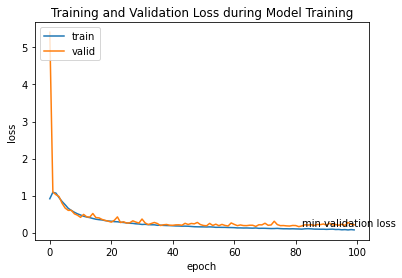

In [26]:
y_v = min(loss_valid_list)
x_v = loss_valid_list.index(y_v)+1
plt.plot(loss_train_list)
plt.plot(loss_valid_list)
plt.annotate("min validation loss",(x_v,y_v))
plt.title('Training and Validation Loss during Model Training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid','minimum'], loc='upper left')
plt.show()

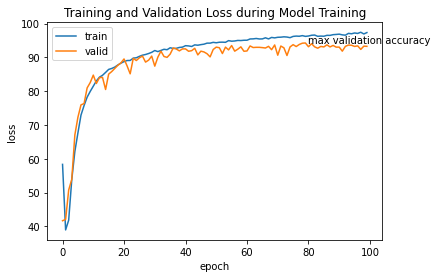

In [31]:
y_a = max(acc_valid_list)
x_a = acc_valid_list.index(y_a)+1
plt.plot(acc_train_list)
plt.plot(acc_valid_list)
plt.annotate("max validation accuracy",(x_a,y_a))
plt.title('Training and Validation Loss during Model Training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [17]:
f1 = open("/home/user/research/resnet18/loss_train.txt","w")
f2 = open("/home/user/research/resnet18/loss_valid.txt","w")
f3 = open("/home/user/research/resnet18/acc_train.txt","w")
f4 = open("/home/user/research/resnet18/acc_valid.txt","w")
for i in range(len(loss_train_list)):
    f1.write(str(loss_train_list[i]))
    f1.write(",")
    f2.write(str(loss_valid_list[i]))
    f2.write(",")
    f3.write(str(acc_train_list[i]))
    f3.write(",")
    f4.write(str(acc_valid_list[i]))
    f4.write(",")
f1.close()
f2.close()
f3.close()
f4.close()